# AutoGluon Object Detection using SageMaker

로컬 개발 환경이 아닌 SageMaker 훈련 인스턴스를 사용하여 훈련 수행

## 1. Build Docker image and Push to ECR
---

In [1]:
%%bash

#!/usr/bin/env bash

echo '{
    "runtimes": {
        "nvidia": {
            "path": "nvidia-container-runtime",
            "runtimeArgs": []
        }
    }
}' > daemon.json

sudo cp daemon.json /etc/docker/daemon.json && rm daemon.json

DAEMON_PATH="/etc/docker"
MEMORY_SIZE=10G

FLAG=$(cat $DAEMON_PATH/daemon.json | jq 'has("data-root")')
# echo $FLAG

if [ "$FLAG" == true ]; then
    echo "Already revised"
else
    echo "Add data-root and default-shm-size=$MEMORY_SIZE"
    sudo cp $DAEMON_PATH/daemon.json $DAEMON_PATH/daemon.json.bak
    sudo cat $DAEMON_PATH/daemon.json.bak | jq '. += {"data-root":"/home/ec2-user/SageMaker/.container/docker","default-shm-size":"'$MEMORY_SIZE'"}' | sudo tee $DAEMON_PATH/daemon.json > /dev/null
    sudo service docker restart
    echo "Docker Restart"
fi

sudo docker info | grep Root

Add data-root and default-shm-size=10G
Docker Restart
 Docker Root Dir: /home/ec2-user/SageMaker/.container/docker


Redirecting to /bin/systemctl restart docker.service


In [2]:
import sagemaker
from sagemaker import utils

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session._region_name

bucket = sagemaker_session.default_bucket()
output_path = f"s3://{bucket}/ag-od-{utils.sagemaker_timestamp()}"

In [3]:
container = "autogluon-objdetect-training-gpu"
tag = "latest"
! ./build_and_push.sh $container $tag docker/Dockerfile.gpu

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  438.5MB
Step 1/16 : ARG CUDA_VER=11.7
Step 2/16 : ARG PYTHON_VERSION=3.9.16
Step 3/16 : FROM 763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:1.13.1-gpu-py39-cu117-ubuntu20.04-sagemaker
 ---> 7f31a6d22c76
Step 4/16 : ENV PYTORCH_SKIP_CUDNN_COMPATIBILITY_CHECK=1
 ---> Using cache
 ---> f7c266a90cbd
Step 5/16 : LABEL maintainer="Amazon AI"
 ---> Using cache
 ---> 7d2b103ba009
Step 6/16 : L

<br>

## 2. Start SageMaker Training Job
---

훈련 과정

1. 훈련 EC2 인스턴스 프로비저닝 
2. 컨테이너 구동을 위한 도커 이미지 및 훈련 데이터 다운로드 
3. 컨테이너 구동
4. 컨테이너 환경에서 훈련 수행
5. 컨테이너 환경에서 S3의 특정 버킷에 저장 
6. 훈련 인스턴스 종료

- 훈련 수행 로직은 아래 예시와 같이 기존 개발 환경과 동일하며 기존 훈련 코드 수정 없이 기존 스크립트에 SageMaker 훈련에 필요한 SageMaker 전용 환경 변수만 추가
- 환경 변수에 대한 내용은  https://github.com/aws/sagemaker-containers#important-environment-variables 참조


In [4]:
import sys
sys.path.append("./ag_scripts")

from ag_scripts.ag_model import (
    AutoGluonSagemakerEstimator,
    AutoGluonNonRepackInferenceModel,
    AutoGluonSagemakerInferenceModel,
    AutoGluonRealtimePredictor,
    AutoGluonBatchPredictor,
)

container_uri = "143656149352.dkr.ecr.us-east-1.amazonaws.com/autogluon-objdetect-training-gpu:latest"

task = 'objdetection-pikachu'
s3_train_path = f"s3://{bucket}/{task}"
!aws s3 sync {task} {s3_train_path}

upload: objdetection-pikachu/annotations/test-coco.json to s3://sagemaker-us-east-1-143656149352/objdetection-pikachu/annotations/test-coco.json
upload: objdetection-pikachu/annotations/train-coco.json to s3://sagemaker-us-east-1-143656149352/objdetection-pikachu/annotations/train-coco.json
upload: objdetection-pikachu/annotations/.ipynb_checkpoints/valid-coco-checkpoint.json to s3://sagemaker-us-east-1-143656149352/objdetection-pikachu/annotations/.ipynb_checkpoints/valid-coco-checkpoint.json
upload: objdetection-pikachu/annotations/valid-coco.json to s3://sagemaker-us-east-1-143656149352/objdetection-pikachu/annotations/valid-coco.json


In [5]:
ag_hyper_params = {
    "checkpoint_name": "yolox_l_8x8_300e_coco",
    "num_gpus": -1,  # use all GPUs
    "val_metric": "map",
    "annotations_path": "annotations/train-coco.json",
    "learning_rate": 3e-5, # we use two stage and detection head has 100x lr
    "per_gpu_batch_size": 8,  # decrease it when model is large
    "max_epochs": 10,  # for the real use case, at least 50
    "check_val_every_n_epoch": 2, # make sure there is at least one validation
    "patience": 3  # Early stop after k consective validations are not the best
}

In [6]:
estimator = AutoGluonSagemakerEstimator(
    custom_image_uri=container_uri,
    role=role,
    entry_point="train.py",
    source_dir="scripts",
    region=region,
    instance_count=1,
    instance_type="ml.g5.xlarge",
    #instance_type="local",
    framework_version="0.7",
    py_version="py39",
    base_job_name="autogluon-objdetect-train",
    volume_size=30,
    disable_profiler=True,
    debugger_hook_config=False,
    hyperparameters=ag_hyper_params
)

In [7]:
job_name = utils.unique_name_from_base("autogluon-objdetect")
estimator.fit(
    {
        "train": s3_train_path,
    },
    job_name=job_name,
    wait=False
)
print(job_name)

INFO:sagemaker:Creating training-job with name: autogluon-objdetect-1684456505-388b


autogluon-objdetect-1684456505-388b


In [9]:
from IPython.core.display import display, HTML

def make_console_link(region, train_job_name, train_task='[Training]'):
    train_job_link = f'<b> {train_task} Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={region}#/jobs/{train_job_name}">Training Job</a></b>'   
    cloudwatch_link = f'<b> {train_task} Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={region}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={train_job_name};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a></b>'
    return train_job_link, cloudwatch_link  
        
train_job_link, cloudwatch_link = make_console_link(region, job_name, '[SageMaker Training]')

display(HTML(train_job_link))
display(HTML(cloudwatch_link))

<br>

## 3. Prediction
---

### Copy S3 model artifacts to local

In [13]:
import os
local_model_dir = './model'
!rm -rf {local_model_dir}
s3_model_path = estimator.model_data
os.makedirs(local_model_dir, exist_ok=True)

In [14]:
%%bash -s "$local_model_dir" "$s3_model_path"
aws s3 cp $2 $1
cd $1
tar -xzvf model.tar.gz

download: s3://sagemaker-us-east-1-143656149352/autogluon-objdetect-1684456505-388b/output/model.tar.gz to model/model.tar.gz
events.out.tfevents.1684457120.algo-1.58.0
df_preprocessor.pkl
data_processors.pkl
assets.json
config.yaml
hparams.yaml
model.ckpt


### Load fine-tuned model

In [17]:
# Load and reset num_gpus
from autogluon.multimodal import MultiModalPredictor
predictor = MultiModalPredictor.load(local_model_dir)
#predictor.set_num_gpus(1)

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.1 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Load pretrained checkpoint: /home/ec2-user/SageMaker/autogluon-objdetect-with-sagemaker-example/model/model.ckpt


### Prediction

In [20]:
from glob import glob
import numpy as np
from scripts.utils import show_detection_result

test_path = f"{task}/images/test" 
test_files = glob(f'{test_path}/*.jpg') + glob(f'{test_path}/*.jpeg') + glob(f'{test_path}/*.png')

Predicting: 0it [00:00, ?it/s]

image     objdetection-pikachu/images/test/pikachu-3_jpg...
bboxes    [{'class': 'pikachu', 'bbox': [109.52859, 70.6...
Name: 0, dtype: object


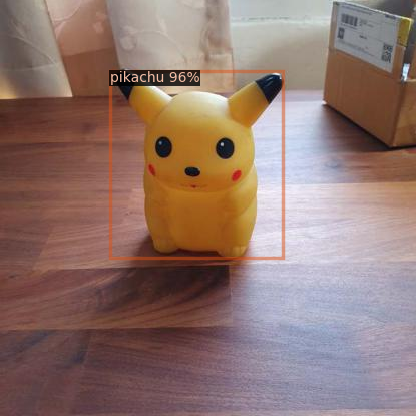

In [23]:
test_idx = np.random.randint(len(test_files))
img_path = test_files[test_idx]
img_result = predictor.predict(img_path).iloc[0]
print(img_result)
show_detection_result(img_path, img_result, 0.5)